In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# READING DATA

In [0]:
dft = pd.read_csv('train_data.csv',nrows=50000)
dfr = pd.read_csv('resources.csv')

In [0]:
print("Number of data points in train data", dft.shape)
print('-'*50)
print("The attributes of data :", dft.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
print("Number of data points in train data", dfr.shape)
print(dfr.columns.values)
dfr.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [0]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(dft.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
dft['Date'] = pd.to_datetime(dft['project_submitted_datetime'])
dft.drop('project_submitted_datetime', axis=1, inplace=True)
dft.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
dft = dft[cols]


dft.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state                Date project_grade_category  \
473             GA 2016-04-27 00:53:00          Grades PreK-2   
41558           WA 2016-04-27 01:05:25             Grades 3-5   

      project_subject_categories project_subject_subcategories  \
473             Applied Learning             Early Development   
41558        Literacy & Language                      Literacy   

                                project_title  \
473    Flexible Seating for Flexible Learning   
41558  Going Deep: The Art of Inner Thinking!   

                                         project_essay_1  \
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  
473                                               2                    1  
41558                                             2                    1

# TEXT PROCESSING

In [0]:
# merge two column text dataframe: 
dft["essay"] = dft["project_essay_1"].map(str) +\
                        dft["project_essay_2"].map(str) + \
                        dft["project_essay_3"].map(str) + \
                        dft["project_essay_4"].map(str)

In [0]:
dft.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state                Date project_grade_category  \
473             GA 2016-04-27 00:53:00          Grades PreK-2   
41558           WA 2016-04-27 01:05:25             Grades 3-5   

      project_subject_categories project_subject_subcategories  \
473             Applied Learning             Early Development   
41558        Literacy & Language                      Literacy   

                                project_title  \
473    Flexible Seating for Flexible Learning   
41558  Going Deep: The Art of Inner Thinking!   

                                         project_essay_1  \
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
473                                               2                    1   
41558                                             2                    1   

                                                   essay  
473    I recently read an article about giving studen...  
41558  My students crave challenge, they eat obstacle...

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
# specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
# general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [0]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Preprocessing of project_subject_categories

In [0]:
catogories = list(dft['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
dft['clean_categories'] = cat_list
dft.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in dft['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

# Preprocessing of project_subject_subcategories

In [0]:
sub_catogories = list(dft['project_subject_subcategories'].values)
# remove special characters from list of strings python:
#https://stackoverflow.com/a/47301924/4084039

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

dft['clean_subcategories'] = sub_cat_list
dft.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: 
#https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in dft['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
# we have to remove the grades from every row
print(dft['project_grade_category'][:20])

473      Grades PreK-2
41558       Grades 3-5
29891       Grades 3-5
23374    Grades PreK-2
49228    Grades PreK-2
7176     Grades PreK-2
35006       Grades 3-5
5145        Grades 3-5
48237      Grades 9-12
46375       Grades 3-5
36468    Grades PreK-2
36358    Grades PreK-2
39438    Grades PreK-2
2521     Grades PreK-2
40180    Grades PreK-2
25460       Grades 6-8
34399       Grades 3-5
5364        Grades 6-8
47478      Grades 9-12
45858       Grades 3-5
Name: project_grade_category, dtype: object


In [0]:
d= list(dft['project_grade_category'].values)
# remove special characters from list of strings python:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

grade_cat_list = []
for i in d:
# consider we have text like this:
    for j in i.split(' '): # # split by space
        j=j.replace('Grades','')# clean grades from the row
    grade_cat_list.append(j.strip())
    
dft['clean_grade'] = grade_cat_list
dft.drop(['project_grade_category'], axis=1, inplace=True)

my_counter = Counter()
for word in dft['clean_grade'].values:
     my_counter.update(word.split())
project_grade_category_dict= dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

# Preparing data for the models

# Test - Train Split

In [0]:
#Splitting Data into train and Test sklearn https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dft,dft['project_is_approved'],test_size = 0.33,stratify= dft['project_is_approved'])

print(y_train.value_counts())
print(y_test.value_counts())

1    28332
0     5168
Name: project_is_approved, dtype: int64
1    13954
0     2546
Name: project_is_approved, dtype: int64


# Text preprocessing


In [0]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())


100%|███████████████████████████████████████████████████████████████████████████| 33500/33500 [00:44<00:00, 754.86it/s]


In [0]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [00:21<00:00, 774.09it/s]


In [0]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:01<00:00, 14599.77it/s]


In [0]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:02<00:00, 16048.01it/s]


# Response coding for Categorical Data

In [0]:
##Step1: Find the counts
X_train_pos = X_train[X_train['project_is_approved'] == 1]# first get all the positives

In [0]:
school_state_pos = {}# take a dictionary
for i in X_train_pos['school_state']:
    if i not in school_state_pos:
     school_state_pos[i]=1
    else:
     school_state_pos[i]+=1
# Python 3
first2pairs = {k: school_state_pos[k] for k in sorted(school_state_pos.keys())[:2]}
print(first2pairs)

{'AK': 86, 'AL': 453}


In [0]:
# For negatives:
X_train_neg = X_train.loc[X_train['project_is_approved'] == 0]# take all the negatives from the train
school_state_neg = {}
for a in X_train_neg['school_state'] :
    if a not in school_state_neg :
     school_state_neg[a] = 1
    else :
     school_state_neg[a] += 1
# Python 3
first2pairs = {k: school_state_neg[k] for k in sorted(school_state_neg.keys())[:2]}
print(first2pairs)

{'AK': 20, 'AL': 72}


In [0]:
#droping the y labels
#https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe-by-column-name
#x_train =
X_train.drop(["project_is_approved"], axis = 1, inplace = True)
#x_test =
X_test.drop(["project_is_approved"], axis = 1, inplace = True)

In [0]:
# for total: probabilitty of cat_attribute= positives/total
school_state_total = {}
for a in X_train['school_state'] :
    if a not in school_state_total :
     school_state_total[a] = 1
    else :
     school_state_total[a] += 1
# Python 3
first2pairs = {k: school_state_total[k] for k in sorted(school_state_total.keys())[:2]}
print(first2pairs)

{'AK': 106, 'AL': 525}


In [0]:
xx = list(school_state_total)[0]
print(xx)
print(school_state_pos['SC'])
print(school_state_neg['SC'])
print(school_state_total['SC'])

PA
1045
174
1219


In [0]:
#Step 2 : Find Probabilities with respect to classes
#For positives probabilities
pos_prob_state = {}
for state in school_state_total.keys():
    pos_prob_state[state] = round(((school_state_pos[state])/float(school_state_total[state])),2)
# Python 3
first2pairs = {k: pos_prob_state[k] for k in sorted(pos_prob_state.keys())[:2]}
print(first2pairs)

{'AK': 0.81, 'AL': 0.86}


In [0]:
#For positives probabilities
neg_prob_state = {}
for state in school_state_total.keys():
    neg_prob_state[state] = round(((school_state_neg[state])/float(school_state_total[state])),2)
# Python 3
first2pairs = {k: neg_prob_state[k] for k in sorted(neg_prob_state.keys())[:2]}
print(first2pairs)

{'AK': 0.19, 'AL': 0.14}


In [0]:
#Step 3 : Apply probabilities to Train data
state_0_train = []
state_1_train = []
for a in X_train["school_state"] :
    state_0_train.append(neg_prob_state[a])
    state_1_train.append(pos_prob_state[a])
# converted to list
X_train["state_0"] =state_0_train
X_train["state_1"] =state_1_train
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
17003      128895  p053468  1ca2208845584568fea559deaaced4ca           Mrs.   
47007       78783  p219543  c334f8a2c0f13530064ff0eee97ff727           Mrs.   

      school_state                Date                  project_title  \
17003           PA 2016-11-12 12:31:12  Backpacks for Fourth Graders!   
47007           AL 2016-09-30 12:54:11       It's All About the Math!   

                                         project_essay_1  \
17003  I have about 55 amazing fourth grade students,...   
47007  My fifth graders are fun, fabulous, and friend...   

                                         project_essay_2 project_essay_3  \
17003  These backpacks will provide my students with ...             NaN   
47007  Students will use the Chromebooks to access th...             NaN   

      project_essay_4                           project_resource_summary  \
17003             NaN  My students need 30 backpacks to carry their s...   
47007             NaN  My students need Laptops to be successful, tec...   

       teacher_number_of_previously_posted_projects  \
17003                                            41   
47007                                             0   

                                                   essay    clean_categories  \
17003  I have about 55 amazing fourth grade students,...  Warmth Care_Hunger   
47007  My fifth graders are fun, fabulous, and friend...        Math_Science   

      clean_subcategories clean_grade  state_0  state_1  
17003  Warmth Care_Hunger         3-5     0.15     0.85  
47007         Mathematics         3-5     0.14     0.86

In [0]:
#Step 4 : Apply probabilities to Test data
# we trained or calculated on the trian_data and apply on the test data.
state_0_test = []
state_1_test = []
for a in X_test["school_state"] :
    state_0_test.append(neg_prob_state[a])
    state_1_test.append(pos_prob_state[a])
X_test["state_0"] =state_0_test
X_test["state_1"] =state_1_test
print(X_test.head(2))

       Unnamed: 0       id                        teacher_id teacher_prefix  \
7874       126211  p069796  86bb752ba5389d7d204ddbd9700ed6ce           Mrs.   
39689      152178  p192197  61a75f8e40dcec4b7ffac6deeb38ddac           Mrs.   

      school_state                Date  \
7874            NC 2016-11-29 16:22:57   
39689           TX 2016-07-07 02:07:16   

                                         project_title  \
7874   Anchored in Excellence Through Digital Learning   
39689                   Putting Our Listening Ears On!   

                                         project_essay_1  \
7874   I am the Academically Gifted (AG) Cluster Teac...   
39689  We are a Title 1 school with the majority of o...   

                                         project_essay_2 project_essay_3  \
7874   The items requested will provide high interest...             NaN   
39689  Use of our iPads is a daily activity in our cl...             NaN   

      project_essay_4                           pr

# For Clean categorical feature (Response coding)


In [0]:
#Step1: Find the counts
X_train.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
17003      128895  p053468  1ca2208845584568fea559deaaced4ca           Mrs.   

      school_state                Date                  project_title  \
17003           PA 2016-11-12 12:31:12  Backpacks for Fourth Graders!   

                                         project_essay_1  \
17003  I have about 55 amazing fourth grade students,...   

                                         project_essay_2 project_essay_3  \
17003  These backpacks will provide my students with ...             NaN   

      project_essay_4                           project_resource_summary  \
17003             NaN  My students need 30 backpacks to carry their s...   

       teacher_number_of_previously_posted_projects  \
17003                                            41   

                                                   essay    clean_categories  \
17003  I have about 55 amazing fourth grade students,...  Warmth Care_Hunger   

      clean_subcategories clean_grade  state_0  state_1  
17003  Warmth Care_Hunger         3-5     0.15     0.85

In [0]:
clean_category_pos = {}
for a in X_train_pos['clean_categories'] :
    for b in a.split():# one datapoint has multile attributes lke Literacy_Language ,Math_Science
        if b not in clean_category_pos :
            clean_category_pos[b] = 1
        else :
            clean_category_pos[b] += 1
# Python 3
first2pairs = {k: clean_category_pos [k] for k in sorted(clean_category_pos .keys())[:5]}
print(first2pairs)

{'AppliedLearning': 3090, 'Care_Hunger': 383, 'Health_Sports': 3666, 'History_Civics': 1550, 'Literacy_Language': 13874}


In [0]:
clean_category_neg = {}
for a in X_train_neg['clean_categories'] :
    for b in a.split():# one datapoint has multile attributes lke Literacy_Language ,Math_Science
        if b not in clean_category_neg :
            clean_category_neg[b] = 1
        else :
            clean_category_neg[b] += 1
# Python 3
first2pairs = {k: clean_category_neg [k] for k in sorted(clean_category_neg .keys())[:5]}
print(first2pairs)


{'AppliedLearning': 643, 'Care_Hunger': 34, 'Health_Sports': 718, 'History_Civics': 248, 'Literacy_Language': 2186}


In [0]:
clean_category_total = {}
for a in X_train['clean_categories'] :
    for b in a.split():
        if b not in clean_category_total :
            clean_category_total[b] = 1
        else :
            clean_category_total[b] += 1
# Python 3
first2pairs = {k: clean_category_total[k] for k in sorted(clean_category_total.keys())[:5]}
print(first2pairs)

{'AppliedLearning': 3733, 'Care_Hunger': 417, 'Health_Sports': 4384, 'History_Civics': 1798, 'Literacy_Language': 16060}


In [0]:
#Step 2 : Find Probabilities with respect to classes
pos_prob_category = {}
for st in clean_category_total.keys():
    pos_prob_category[st] = round(((clean_category_pos[st])/float(clean_category_total[st])),2)
    
first2pairs = {k: pos_prob_category[k] for k in sorted( pos_prob_category.keys())[:5]}
print(first2pairs)

{'AppliedLearning': 0.83, 'Care_Hunger': 0.92, 'Health_Sports': 0.84, 'History_Civics': 0.86, 'Literacy_Language': 0.86}


In [0]:
neg_prob_category = {}
for st in clean_category_total.keys():
    neg_prob_category[st] = round(((clean_category_neg[st])/float(clean_category_total[st])),2)
    
first2pairs = {k: neg_prob_category[k] for k in sorted( neg_prob_category.keys())[:5]}
print(first2pairs)

{'AppliedLearning': 0.17, 'Care_Hunger': 0.08, 'Health_Sports': 0.16, 'History_Civics': 0.14, 'Literacy_Language': 0.14}


In [0]:
#Step 3 : Apply probabilities to Train data
cat_0_train = []
cat_1_train = []
for a in X_train["clean_categories"] :
    b = a.split()# if len is one then just do same as we done in school_state
    if len(b) == 1 :
        cat_0_train.append(neg_prob_category[a])
        cat_1_train.append(pos_prob_category[a])
    else :
# max we have upto 2 length of category for one data point
        if len(b) ==3:
            c = neg_prob_category[b[0]]
            d = neg_prob_category[b[1]]
            d1=neg_prob_category[b[2]]
            e = pos_prob_category[b[0]]
            f = pos_prob_category[b[1]]
            f1 = pos_prob_category[b[2]]
            cat_0_train.append(round((c*d*d1),2))
            cat_1_train.append(round((e*f*f1),2))
        else:
            c = neg_prob_category[b[0]]
            d = neg_prob_category[b[1]]
            e = pos_prob_category[b[0]]
            f = pos_prob_category[b[1]]
            cat_0_train.append(round((c*d),2))
            cat_1_train.append(round((e*f),2))
X_train["cat_0"] = cat_0_train
X_train["cat_1"] = cat_1_train
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
17003      128895  p053468  1ca2208845584568fea559deaaced4ca           Mrs.   
47007       78783  p219543  c334f8a2c0f13530064ff0eee97ff727           Mrs.   

      school_state                Date                  project_title  \
17003           PA 2016-11-12 12:31:12  Backpacks for Fourth Graders!   
47007           AL 2016-09-30 12:54:11       It's All About the Math!   

                                         project_essay_1  \
17003  I have about 55 amazing fourth grade students,...   
47007  My fifth graders are fun, fabulous, and friend...   

                                         project_essay_2 project_essay_3  ...  \
17003  These backpacks will provide my students with ...             NaN  ...   
47007  Students will use the Chromebooks to access th...             NaN  ...   

                                project_resource_summary  \
17003  My students need 30 backpacks to carry their s...   
47007  My students need Laptops to be successful, tec...   

      teacher_number_of_previously_posted_projects  \
17003                                           41   
47007                                            0   

                                                   essay    clean_categories  \
17003  I have about 55 amazing fourth grade students,...  Warmth Care_Hunger   
47007  My fifth graders are fun, fabulous, and friend...        Math_Science   

      clean_subcategories clean_grade state_0  state_1  cat_0  cat_1  
17003  Warmth Care_Hunger         3-5    0.15     0.85   0.01   0.85  
47007         Mathematics         3-5    0.14     0.86   0.16   0.84  

[2 rows x 21 columns]

In [0]:
#Step 4 : Apply probabilities to Test data
cat_0_test = []
cat_1_test = []
for a in X_test["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_test.append(neg_prob_category[a])
        cat_1_test.append(pos_prob_category[a])
    else :
        if len(b) ==3:
            c = neg_prob_category[b[0]]
            d = neg_prob_category[b[1]]
            d1=neg_prob_category[b[2]]
            e = pos_prob_category[b[0]]
            f = pos_prob_category[b[1]]
            f1 = pos_prob_category[b[2]]
            cat_0_test.append(round((c*d*d1),2))
            cat_1_test.append(round((e*f*f1),2))
        else:
            c = neg_prob_category[b[0]]
            d = neg_prob_category[b[1]]
            e = pos_prob_category[b[0]]
            f = pos_prob_category[b[1]]
            cat_0_test.append(round((c*d),2))
            cat_1_test.append(round((e*f),2))
X_test["cat_0"] = cat_0_test
X_test["cat_1"] = cat_1_test
X_test.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
7874      126211  p069796  86bb752ba5389d7d204ddbd9700ed6ce           Mrs.   

     school_state                Date  \
7874           NC 2016-11-29 16:22:57   

                                        project_title  \
7874  Anchored in Excellence Through Digital Learning   

                                        project_essay_1  \
7874  I am the Academically Gifted (AG) Cluster Teac...   

                                        project_essay_2 project_essay_3  ...  \
7874  The items requested will provide high interest...             NaN  ...   

                               project_resource_summary  \
7874  My students need these supplies to further enr...   

     teacher_number_of_previously_posted_projects  \
7874                                            0   

                                                  essay  \
7874  I am the Academically Gifted (AG) Cluster Teac...   

                    clean_categories   clean_subcategories clean_grade  \
7874  Literacy_Language Math_Science  Literacy Mathematics         3-5   

     state_0  state_1  cat_0  cat_1  
7874    0.14     0.86   0.02   0.72  

[1 rows x 21 columns]

# Sub-Categories of Projects- Response Coding

In [0]:
#Find counts of each
clean_subcategory_pos = {}
for a in X_train_pos['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_pos :
            clean_subcategory_pos[b] = 1
        else :
            clean_subcategory_pos[b] += 1
first2pairs = {k: clean_subcategory_pos[k] for k in sorted( clean_subcategory_pos .keys())[:5]}
print(first2pairs)

{'AppliedSciences': 2729, 'Care_Hunger': 383, 'CharacterEducation': 539, 'Civics_Government': 216, 'College_CareerPrep': 649}


In [0]:
clean_subcategory_neg = {}
for a in X_train_neg['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_neg :
            clean_subcategory_neg[b] = 1
        else :
            clean_subcategory_neg[b] += 1
first2pairs = {k: clean_subcategory_neg[k] for k in sorted( clean_subcategory_neg .keys())[:5]}
print(first2pairs)

{'AppliedSciences': 578, 'Care_Hunger': 34, 'CharacterEducation': 124, 'Civics_Government': 38, 'College_CareerPrep': 120}


In [0]:
clean_subcategory_total = {}
for a in X_train['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_total :
            clean_subcategory_total[b] = 1
        else :
            clean_subcategory_total[b] += 1
first2pairs = {k: clean_subcategory_total[k] for k in sorted( clean_subcategory_total.keys())[:5]}
print(first2pairs)

{'AppliedSciences': 3307, 'Care_Hunger': 417, 'CharacterEducation': 663, 'Civics_Government': 254, 'College_CareerPrep': 769}


In [0]:
#Step 2 : Find Probabilities with respect to classes
pos_prob_subcategory = {}
for sw in clean_subcategory_total.keys():
    pos_prob_subcategory[sw] = round(((clean_subcategory_pos[sw])/float(clean_subcategory_total[sw])),2)
    
first2pairs = {k: pos_prob_subcategory[k] for k in sorted( pos_prob_subcategory.keys())[:5]}
print(first2pairs)

{'AppliedSciences': 0.83, 'Care_Hunger': 0.92, 'CharacterEducation': 0.81, 'Civics_Government': 0.85, 'College_CareerPrep': 0.84}


In [0]:
neg_prob_subcategory = {}
for sw in clean_subcategory_total.keys():
    neg_prob_subcategory[sw] =round (((clean_subcategory_neg[sw])/float(clean_subcategory_total[sw])),2)

first2pairs = {k: neg_prob_subcategory[k] for k in sorted( neg_prob_subcategory.keys())[:5]}
print(first2pairs)

{'AppliedSciences': 0.17, 'Care_Hunger': 0.08, 'CharacterEducation': 0.19, 'Civics_Government': 0.15, 'College_CareerPrep': 0.16}


In [0]:
#Step 3 : Apply probabilities to Train data
subcat_0_train = []
subcat_1_train = []
for a in X_train["clean_subcategories"]:
    b = a.split()
    if len(b) == 1 :
        subcat_0_train.append(neg_prob_subcategory[a])
        subcat_1_train.append(pos_prob_subcategory[a])
    else :
        if len(b) ==3:# max lenght of categories in one datapoint is 3
            c = neg_prob_subcategory[b[0]]
            d = neg_prob_subcategory[b[1]]
            d1=neg_prob_subcategory[b[2]]
            e = pos_prob_subcategory[b[0]]
            f = pos_prob_subcategory[b[1]]
            f1 = pos_prob_subcategory[b[2]]
            subcat_0_train.append(round((c*d*d1),2))
            subcat_1_train.append(round((e*f*f1),2))
        else:
            c = neg_prob_subcategory[b[0]]
            d = neg_prob_subcategory[b[1]]
            e = pos_prob_subcategory[b[0]]
            f = pos_prob_subcategory[b[1]]
    
            subcat_0_train.append(round((c*d),2))
            subcat_1_train.append(round((e*f),2))
    
X_train["subcat_0"] = subcat_0_train
X_train["subcat_1"] = subcat_1_train
X_train.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
17003      128895  p053468  1ca2208845584568fea559deaaced4ca           Mrs.   

      school_state                Date                  project_title  \
17003           PA 2016-11-12 12:31:12  Backpacks for Fourth Graders!   

                                         project_essay_1  \
17003  I have about 55 amazing fourth grade students,...   

                                         project_essay_2 project_essay_3  ...  \
17003  These backpacks will provide my students with ...             NaN  ...   

                                                   essay    clean_categories  \
17003  I have about 55 amazing fourth grade students,...  Warmth Care_Hunger   

       clean_subcategories clean_grade state_0 state_1 cat_0  cat_1  subcat_0  \
17003   Warmth Care_Hunger         3-5    0.15    0.85  0.01   0.85      0.01   

       subcat_1  
17003      0.85  

[1 rows x 23 columns]

In [0]:
#Step 4 : Apply probabilities to Test data
subcat_0_test = []
subcat_1_test = []
for a in X_test["clean_subcategories"]:
    b = a.split()
    if len(b) == 1 :
        subcat_0_test.append(neg_prob_subcategory[a])
        subcat_1_test.append(pos_prob_subcategory[a])
    else :
        if len(b) ==3:# max lenght of categories in one datapoint is 3
            c = neg_prob_subcategory[b[0]]
            d = neg_prob_subcategory[b[1]]
            d1=neg_prob_subcategory[b[2]]
            e = pos_prob_subcategory[b[0]]
            f = pos_prob_subcategory[b[1]]
            f1 = pos_prob_subcategory[b[2]]
            subcat_0_test.append(round((c*d*d1),2))
            subcat_1_test.append(round((e*f*f1),2))
        else:
            c = neg_prob_subcategory[b[0]]
            d = neg_prob_subcategory[b[1]]
            e = pos_prob_subcategory[b[0]]
            f = pos_prob_subcategory[b[1]]
            subcat_0_test.append(round((c*d),2))
            subcat_1_test.append(round((e*f),2))
X_test["subcat_0"] = subcat_0_test
X_test["subcat_1"] = subcat_1_test
X_test.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
7874      126211  p069796  86bb752ba5389d7d204ddbd9700ed6ce           Mrs.   

     school_state                Date  \
7874           NC 2016-11-29 16:22:57   

                                        project_title  \
7874  Anchored in Excellence Through Digital Learning   

                                        project_essay_1  \
7874  I am the Academically Gifted (AG) Cluster Teac...   

                                        project_essay_2 project_essay_3  ...  \
7874  The items requested will provide high interest...             NaN  ...   

                                                  essay  \
7874  I am the Academically Gifted (AG) Cluster Teac...   

                    clean_categories   clean_subcategories clean_grade  \
7874  Literacy_Language Math_Science  Literacy Mathematics         3-5   

     state_0 state_1 cat_0  cat_1  subcat_0  subcat_1  
7874    0.14    0.86  0.02   0.72      0.02      0.74  

[1 rows x 23 columns]

In [0]:
#Project Grade Category- Response Coding
#Step 1 : Find counts of each
project_grade_pos = {}
for a in X_train_pos['clean_grade'] :
    if a not in project_grade_pos :
        project_grade_pos[a] = 1
    else :
        project_grade_pos[a] += 1
first2pairs = {k: project_grade_pos[k] for k in sorted( project_grade_pos.keys())[:5]}
print(first2pairs)

{'3-5': 9648, '6-8': 4327, '9-12': 2804, 'PreK-2': 11553}


In [0]:
project_grade_neg = {}
for a in X_train_neg['clean_grade'] :
    if a not in project_grade_neg :
       project_grade_neg[a] = 1
    else :
       project_grade_neg[a] += 1
first2pairs = {k: project_grade_neg [k] for k in sorted( project_grade_neg .keys())[:5]}
print(first2pairs)


{'3-5': 1671, '6-8': 823, '9-12': 563, 'PreK-2': 2111}


In [0]:
project_grade_total = {}
for a in X_train['clean_grade'] :
    if a not in project_grade_total :
        project_grade_total[a] = 1
    else :
        project_grade_total[a] += 1
first2pairs = {k: project_grade_total [k] for k in sorted( project_grade_total .keys())[:5]}
print(first2pairs)

{'3-5': 11319, '6-8': 5150, '9-12': 3367, 'PreK-2': 13664}


In [0]:
#Step 2 : Find Probabilities with respect to classes
pos_prob_grade_cat = {}
for sq in project_grade_total.keys():
    pos_prob_grade_cat[sq] = round(((project_grade_pos[sq])/float(project_grade_total[sq])),2)
    
first2pairs = {k: pos_prob_grade_cat [k] for k in sorted( pos_prob_grade_cat .keys())[:5]}
print(first2pairs)

{'3-5': 0.85, '6-8': 0.84, '9-12': 0.83, 'PreK-2': 0.85}


In [0]:
neg_prob_grade_cat = {}
for sq in project_grade_total.keys():
    neg_prob_grade_cat[sq] =round(( (project_grade_neg[sq])/float(project_grade_total[sq])),2)

first2pairs = {k: neg_prob_grade_cat [k] for k in sorted( neg_prob_grade_cat .keys())[:5]}
print(first2pairs)


{'3-5': 0.15, '6-8': 0.16, '9-12': 0.17, 'PreK-2': 0.15}


In [0]:
#Step 3 : Apply probabilities to Train data
proj_grade_0_train = []
proj_grade_1_train = []
for a in X_train["clean_grade"] :
    proj_grade_0_train.append(neg_prob_grade_cat[a])
    proj_grade_1_train.append(pos_prob_grade_cat[a])
X_train["proj_grade_0"] = proj_grade_0_train
X_train["proj_grade_1"] = proj_grade_1_train
X_train.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
17003      128895  p053468  1ca2208845584568fea559deaaced4ca           Mrs.   

      school_state                Date                  project_title  \
17003           PA 2016-11-12 12:31:12  Backpacks for Fourth Graders!   

                                         project_essay_1  \
17003  I have about 55 amazing fourth grade students,...   

                                         project_essay_2 project_essay_3  ...  \
17003  These backpacks will provide my students with ...             NaN  ...   

      clean_subcategories clean_grade  state_0 state_1 cat_0 cat_1 subcat_0  \
17003  Warmth Care_Hunger         3-5     0.15    0.85  0.01  0.85     0.01   

       subcat_1  proj_grade_0  proj_grade_1  
17003      0.85          0.15          0.85  

[1 rows x 25 columns]

In [0]:
#Step 4 : Apply probabilities to Test data
proj_grade_0_test = []
proj_grade_1_test = []
for a in X_test["clean_grade"] :
    proj_grade_0_test.append(neg_prob_grade_cat[a])
    proj_grade_1_test.append(pos_prob_grade_cat[a])
X_test["proj_grade_0"] = proj_grade_0_test
X_test["proj_grade_1"] = proj_grade_1_test
X_test.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
7874      126211  p069796  86bb752ba5389d7d204ddbd9700ed6ce           Mrs.   

     school_state                Date  \
7874           NC 2016-11-29 16:22:57   

                                        project_title  \
7874  Anchored in Excellence Through Digital Learning   

                                        project_essay_1  \
7874  I am the Academically Gifted (AG) Cluster Teac...   

                                        project_essay_2 project_essay_3  ...  \
7874  The items requested will provide high interest...             NaN  ...   

       clean_subcategories clean_grade  state_0 state_1 cat_0 cat_1 subcat_0  \
7874  Literacy Mathematics         3-5     0.14    0.86  0.02  0.72     0.02   

      subcat_1  proj_grade_0  proj_grade_1  
7874      0.74          0.15          0.85  

[1 rows x 25 columns]

# Teacher Prefix- Response Coding

In [0]:
#Step 1 : Find counts of each
teacher_prefix_pos = {}
for a in X_train_pos['teacher_prefix'] :
    if a not in teacher_prefix_pos :
        teacher_prefix_pos[a] = 1
    else :
        teacher_prefix_pos[a] += 1

In [0]:
#teacher_prefix_pos[np.nan]=0
teacher_prefix_pos

{'Mrs.': 14936, 'Ms.': 10104, 'Mr.': 2724, 'Teacher': 565, 'Dr.': 1, nan: 2}

In [0]:
teacher_prefix_neg = {}
for a in X_train_neg['teacher_prefix'] :
    if a not in teacher_prefix_neg :
       teacher_prefix_neg[a] = 1
    else :
        teacher_prefix_neg[a] += 1
teacher_prefix_neg[np.nan]=0
teacher_prefix_neg

{'Mr.': 533, 'Ms.': 1886, 'Mrs.': 2602, 'Teacher': 146, 'Dr.': 1, nan: 0}

In [0]:
teacher_prefix_total = {}
for a in X_train['teacher_prefix'] :
    if a not in teacher_prefix_total :
        teacher_prefix_total[a] = 1
    else :
        teacher_prefix_total[a] += 1# first2pairs = {k: teacher_prefix_total [k] for k in sorted(teacher_prefix_total .keys())[:5]}

In [0]:
#Step 2 : Find Probabilities with respect to classes
pos_prob_teacher_prefix = {}

for sw in teacher_prefix_total.keys():
    pos_prob_teacher_prefix[sw] =round(((teacher_prefix_pos[sw])/float(teacher_prefix_total[sw])),2)

In [0]:
neg_prob_teacher_prefix = {}

for sw in teacher_prefix_total.keys():
    neg_prob_teacher_prefix[sw] =round(((teacher_prefix_neg[sw])/float(teacher_prefix_total[sw])),2)

In [0]:
#Step 3 : Apply probabilities to Train data
teacher_prefix_0_train = []
teacher_prefix_1_train = []
for a in X_train["teacher_prefix"] :
    teacher_prefix_0_train.append(neg_prob_teacher_prefix[a])
    teacher_prefix_1_train.append(pos_prob_teacher_prefix[a])
X_train["teacher_prefix_0"] = teacher_prefix_0_train
X_train["teacher_prefix_1"] = teacher_prefix_1_train

In [0]:
#Step 4 : Apply probabilities to Test data
teacher_prefix_0_test = []
teacher_prefix_1_test = []
for a in X_test["teacher_prefix"] :
    teacher_prefix_0_test.append(neg_prob_teacher_prefix[a])
    teacher_prefix_1_test.append(pos_prob_teacher_prefix[a])
X_test["teacher_prefix_1"] = teacher_prefix_1_test
X_test["teacher_prefix_0"] = teacher_prefix_0_test


# Encoding numerical, Categorical features

In [0]:
X_train_essay=preprocessed_essays_train
X_test_essay=preprocessed_essays_test

X_train_title=preprocessed_titles_train
X_test_title=preprocessed_titles_test
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer6 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))# its a countvectors used for convert text to vectors
vectorizer6.fit(X_train_essay)# that is learned from trainned data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer6.transform(X_train_essay)
X_test_bow = vectorizer6.transform(X_test_essay)
print("After vectorizations")

print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)
# # so the dimension of alll are the same by using first fit and then transform
# print(vectorizer6.get_feature_names())
fb=vectorizer6.get_feature_names()

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


In [0]:
vectorizer7 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer7.fit(X_train_title)# that is learned from trainned data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow_title = vectorizer7.transform(X_train_title)
X_test_bow_title = vectorizer7.transform(X_test_title)
print("After vectorizations")
print(X_train_bow_title.shape, y_train.shape)
print(X_test_bow_title.shape, y_test.shape)
print("="*100)
# so the dimension of alll are the same by using first fit and then transform
ft=vectorizer7.get_feature_names()

After vectorizations
(33500, 2335) (33500,)
(16500, 2335) (16500,)


In [0]:
#for titles
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer8 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))# its a countvectors used for convert text to vectors
vectorizer8.fit(X_train_title)# that is learned from trainned data
# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_title = vectorizer8.transform(X_train_title)
X_test_tf_title = vectorizer8.transform(X_test_title)
print("After vectorizations")
print(X_train_tf_title.shape, y_train.shape)
print(X_test_tf_title.shape, y_test.shape)
print("="*100)
# so the dimension of alll are the same by using first fit and then transform
fb1=vectorizer8.get_feature_names()


After vectorizations
(33500, 2335) (33500,)
(16500, 2335) (16500,)


In [0]:
#for essay
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer9 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))# its a countvectors used for convert text to vectors
vectorizer9.fit(X_train_essay)# that is learned from trainned data
# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_essay = vectorizer9.transform(X_train_essay)
X_test_tf_essay = vectorizer9.transform(X_test_essay)
print("After vectorizations")
print(X_train_tf_essay.shape, y_train.shape)
print(X_test_tf_essay.shape, y_test.shape)
print("="*100)
# so the dimension of alll are the same by using first fit and then transform
ft1=vectorizer9.get_feature_names()

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


# Using Pretrained Models : AVG W2V

In [0]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model


In [0]:
 model = loadGloveModel('glove.42B.300d.txt')

Loading Glove Model


1917495it [08:40, 3685.22it/s]


Done. 1917495  words loaded!


In [0]:
glove_words = set(model.keys()) 

In [0]:
#for essay
# average Word2Vec
# compute average word2vec for each review.
def func(wordlist):
    
  train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(wordlist): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length # we are taking the 300dimensions very large
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_vectors.append(vector)
    
  print(len(train_avg_w2v_vectors))
  print(len(train_avg_w2v_vectors[0]))
  return train_avg_w2v_vectors

In [0]:
train_avg_w2v_vectors=func(preprocessed_essays_train)
test_avg_w2v_vectors=func(preprocessed_essays_test)
#for titles
test_avg_w2v_vectors_title=func(preprocessed_titles_test)
train_avg_w2v_vectors_title=func(preprocessed_titles_train)

100%|██████████████████████████████████████████████████████████████████████████| 33500/33500 [00:19<00:00, 1748.29it/s]


33500
300


100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:09<00:00, 1813.85it/s]


16500
300


100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 35436.82it/s]


16500
300


100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 33629.75it/s]


33500
300


# Using Pretrained Models: TFIDF weighted W2V

In [0]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
def tf_idf_done(word_list):
    train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(word_list): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split():#.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
              #vec = model.wv[word]  
              vec = model[word] # getting the vector for each word
# here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        train_title_tfidf_w2v_vectors.append(vector)
    print(len(train_title_tfidf_w2v_vectors))
    print(len(train_title_tfidf_w2v_vectors[0]))
    return train_title_tfidf_w2v_vectors


In [0]:
#train_title_tfidf_w2v_vectors=tf_idf_done(tf_idf_train_title)
#train_title_tfidf_w2v_vector
train_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_train)
test_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_test)


100%|███████████████████████████████████████████████████████████████████████████| 33500/33500 [02:29<00:00, 224.46it/s]


33500
300


100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [01:14<00:00, 222.22it/s]


16500
300


In [0]:
#train_title_tfidf_w2v_vectors=tf_idf_done(tf_idf_train_title)
#train_title_tfidf_w2v_vector
train_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_train)
test_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_test)

100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:02<00:00, 15137.79it/s]


33500
300


100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 17551.94it/s]


16500
300


# Vectorizing Numerical features

In [0]:
price_data = dfr.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
dft = pd.merge(dft, price_data, on='id', how='left')
print(price_data.head(2))
# we also have to do this in tran,test and cv
# so also merge the resource data with the trian,cv and test
X_train = pd.merge(X_train, price_data, on = "id", how = "left")
#print(x_train.columns)
X_test = pd.merge(X_test, price_data, on = "id", how = "left")

        id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21


In [0]:
#standardization
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviationof this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above mean and variance.
train_price_standar = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
test_price_standar = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

In [0]:
# previous_year_projects
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
train_prev_proj_standar =price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
# Now standardize the data with above maen and variance.
test_prev_proj_standar =price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

In [0]:
price_scalar.fit(X_train['quantity'].values.reshape(-1,1)) # finding the mean and standarddeviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
train_qnty_standar = price_scalar.transform(X_train['quantity'].values.reshape(-1, 1))
# Now standardize the data with above mean and variance.
test_qnty_standar = price_scalar.transform(X_test['quantity'].values.reshape(-1, 1))

# merging


In [0]:
state_0_train=X_train["state_0"].values.reshape(-1,1)
state_1_train=X_train["state_1"].values.reshape(-1,1)
cat_0_train=X_train["cat_0"].values.reshape(-1,1)
cat_1_train=X_train["cat_1"].values.reshape(-1,1)
subcat_1_train=X_train["subcat_1"].values.reshape(-1,1)
subcat_0_train=X_train["subcat_0"].values.reshape(-1,1)
proj_grade_0_train=X_train["proj_grade_0"].values.reshape(-1,1)
proj_grade_1_train=X_train["proj_grade_1"].values.reshape(-1,1)
teacher_prefix_0_train=X_train["teacher_prefix_0"].values.reshape(-1,1)
teacher_prefix_1_train=X_train["teacher_prefix_1"].values.reshape(-1,1)

state_0_test=X_test["state_0"].values.reshape(-1,1)
state_1_test=X_test["state_1"].values.reshape(-1,1)
cat_0_test=X_test["cat_0"].values.reshape(-1,1)
cat_1_test=X_test["cat_1"].values.reshape(-1,1)
subcat_1_test=X_test["subcat_1"].values.reshape(-1,1)
subcat_0_test=X_test["subcat_0"].values.reshape(-1,1)
proj_grade_0_test=X_test["proj_grade_0"].values.reshape(-1,1)
proj_grade_1_test=X_test["proj_grade_1"].values.reshape(-1,1)
teacher_prefix_0_test=X_test["teacher_prefix_0"].values.reshape(-1,1)
teacher_prefix_1_test=X_test["teacher_prefix_1"].values.reshape(-1,1)



from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx

X_set1_train = hstack((X_train_bow_title,X_train_bow,state_0_train,state_1_train,
                       cat_0_train,cat_1_train,subcat_1_train,subcat_0_train,
                       proj_grade_0_train,proj_grade_1_train,teacher_prefix_0_train,teacher_prefix_1_train,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar))# allnumericals
print(X_set1_train.shape, y_train.shape)

(33500, 7348) (33500,)


In [0]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set1_test = hstack((X_test_bow_title,X_test_bow,state_0_test,state_1_test,cat_0_test,cat_1_test,subcat_1_test,subcat_0_test,
                      proj_grade_0_test,proj_grade_1_test,teacher_prefix_0_test,teacher_prefix_1_test,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar))
print(X_set1_test.shape, y_test.shape)

(16500, 7348) (16500,)


In [0]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set2_train = hstack((X_train_tf_essay,X_train_tf_title,state_0_train,state_1_train,cat_0_train,
                       cat_1_train,subcat_1_train,subcat_0_train,
                       proj_grade_0_train,proj_grade_1_train,teacher_prefix_0_train,teacher_prefix_1_train,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar)).tocsr()
print(X_set2_train.shape, y_train.shape)

(33500, 7348) (33500,)


In [0]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set2_test = hstack((X_test_tf_essay,X_test_tf_title,state_0_test,state_1_test,
                      cat_0_test,cat_1_test,subcat_1_test,subcat_0_test,
                      proj_grade_0_test,proj_grade_1_test,teacher_prefix_0_test,teacher_prefix_1_test,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar)).tocsr()
print(X_set2_test.shape, y_test.shape)

(16500, 7348) (16500,)


In [0]:
import numpy
train_avg_w2v_vectors=numpy.array(train_avg_w2v_vectors)
train_avg_w2v_vectors_title=numpy.array(train_avg_w2v_vectors_title)

print(cat_0_train.shape)
print(cat_1_train.shape)
print(subcat_0_train.shape)
print(subcat_1_train.shape)
print(state_0_train.shape)
print(state_1_train.shape)
print(proj_grade_0_train.shape)
print(proj_grade_1_train.shape)
print(teacher_prefix_0_train.shape)
print(teacher_prefix_1_train.shape)
print(train_price_standar.shape)
print(train_qnty_standar.shape)
print(train_prev_proj_standar.shape)
print(train_avg_w2v_vectors.shape)
print(train_avg_w2v_vectors_title.shape)

(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 1)
(33500, 300)
(33500, 300)


In [0]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set3_train = np.hstack((cat_0_train,cat_1_train,subcat_0_train,subcat_1_train,state_0_train,state_1_train,
                          proj_grade_0_train,proj_grade_1_train,teacher_prefix_0_train,
                          teacher_prefix_1_train,train_price_standar,train_qnty_standar,
                          train_prev_proj_standar, train_avg_w2v_vectors,train_avg_w2v_vectors_title ))
print(X_set3_train.shape, y_train.shape)

(33500, 613) (33500,)


In [0]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set3_test =np. hstack((cat_0_test,cat_1_test,subcat_0_test,subcat_1_test,state_0_test,state_1_test,proj_grade_0_test,
                         proj_grade_1_test,teacher_prefix_0_test,teacher_prefix_1_test,
                         test_price_standar,test_qnty_standar,test_prev_proj_standar,test_avg_w2v_vectors,test_avg_w2v_vectors_title ))
print(X_set3_test.shape, y_test.shape)

(16500, 613) (16500,)


In [0]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_train = np.hstack((cat_0_train,cat_1_train,subcat_0_train,subcat_1_train,state_0_train,state_1_train,
                          proj_grade_0_train,proj_grade_1_train,teacher_prefix_0_train,
                          teacher_prefix_1_train,train_price_standar,train_qnty_standar,
                          train_prev_proj_standar, train_tfidf_w2v_vectors,train_title_tfidf_w2v_vectors))
print(X_set4_train.shape, y_train.shape)

(33500, 613) (33500,)


In [0]:
from scipy.sparse import hstack
# use the np.hstack othersize it shows error
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_test = np.hstack((cat_0_test,cat_1_test,subcat_0_test,subcat_1_test,state_0_test,state_1_test,proj_grade_0_test,
                         proj_grade_1_test,teacher_prefix_0_test,teacher_prefix_1_test,
                         test_price_standar,test_qnty_standar,test_prev_proj_standar,test_tfidf_w2v_vectors,test_title_tfidf_w2v_vectors))
print(X_set4_test.shape, y_test.shape)

(16500, 613) (16500,)


# Random Forest on BOW

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt1 = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf1 = GridSearchCV(dt1, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se1 = clf1.fit(X_set1_train, y_train)

In [0]:
clf1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

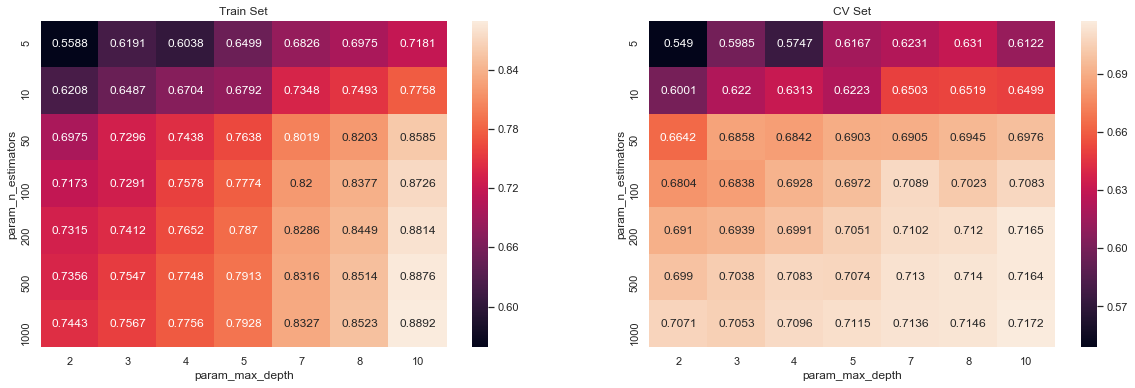

In [0]:
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:
#Best Estimator and Best tune parameters
print(clf1.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf1.score(X_set1_train,y_train))
print(clf1.score(X_set1_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.8591198910180002
0.718893219005641


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [1000], 'max_depth':[10]}]

# Fitting Model to Hyper-Parameter Curve

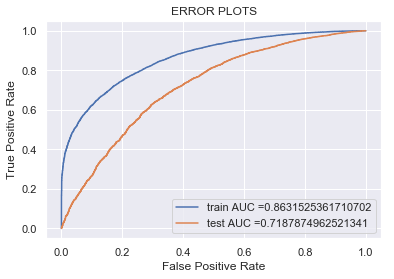

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_set1_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set1_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set1_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [0]:
#Confusion Matrix

def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.6 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.44 for threshold 0.52


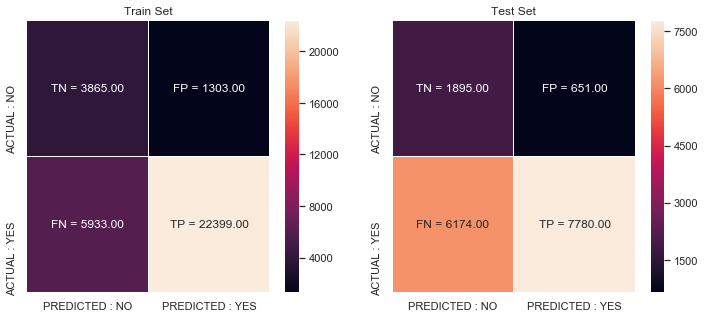

In [0]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Random Forest on TFIDF

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt2 = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf2 = GridSearchCV(dt2, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se2 = clf2.fit(X_set2_train, y_train)

Text(0.5, 1.0, 'CV Set')

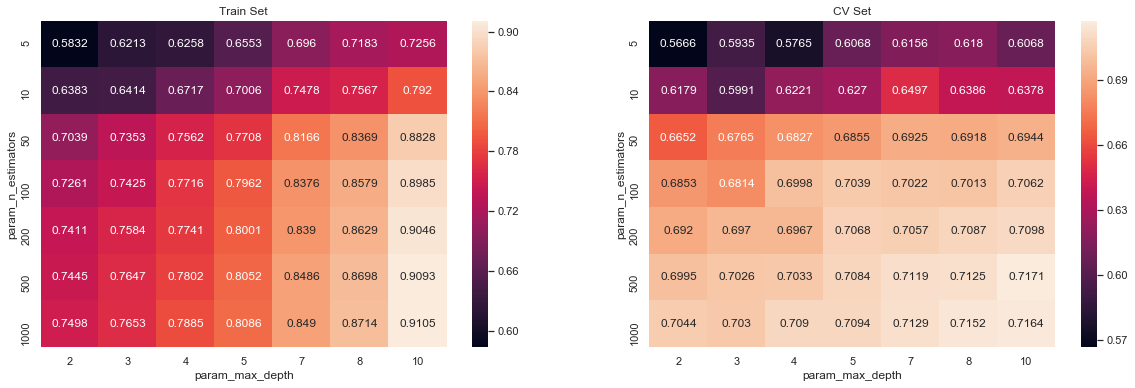

In [0]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf2.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

In [0]:
#Best Estimator and Best tune parameters
print(clf2.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf2.score(X_set2_train,y_train))
print(clf2.score(X_set2_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.8792116305382137
0.7161271025063725


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [500], 'max_depth':[10]}]

# Fitting Model to Hyper-Parameter Curve

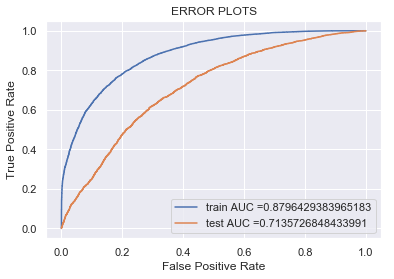

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_set2_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set2_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set2_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.63 for threshold 0.51
the maximum value of tpr*(1-fpr) 0.44 for threshold 0.51


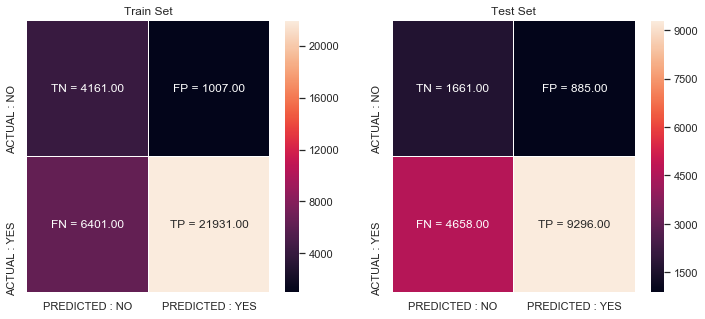

In [0]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Random Forest on AVG W2V

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt3 = RandomForestClassifier(class_weight='balanced',min_samples_split=3)
parameters ={'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf3 = GridSearchCV(dt3, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se3= clf3.fit(X_set3_train, y_train)

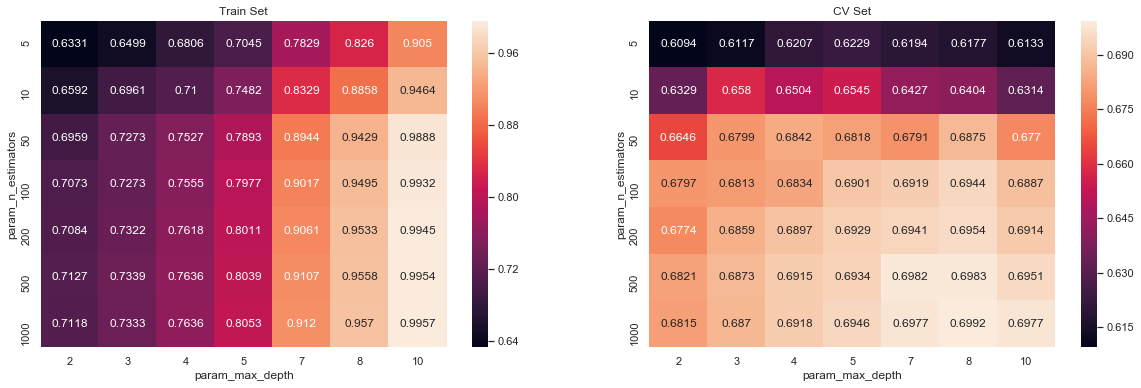

In [0]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf3.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:
#*Best Estimator and best tune parameteR
print(clf3.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf3.score(X_set3_train,y_train))
print(clf3.score(X_set3_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.9231095395201261
0.7066243693086058


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [1000], 'max_depth':[8] } ]

# Fitting Model to Hyper-Parameter Curve:

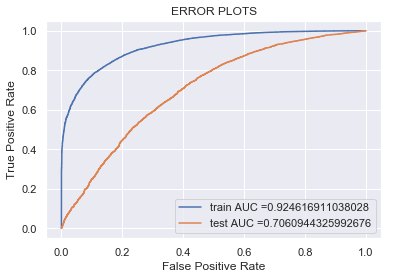

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_set3_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set3_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set3_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.7 for threshold 0.52
the maximum value of tpr*(1-fpr) 0.43 for threshold 0.56


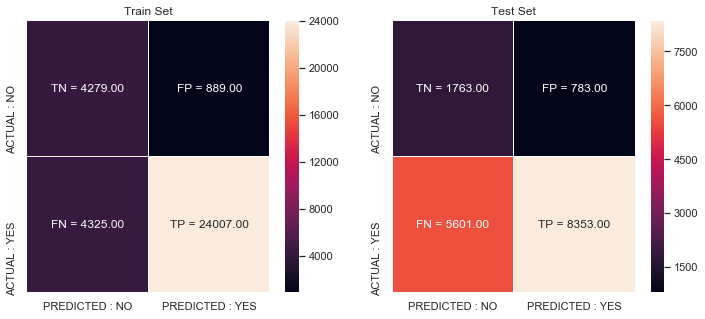

In [0]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Random Forest on td_idf W2V

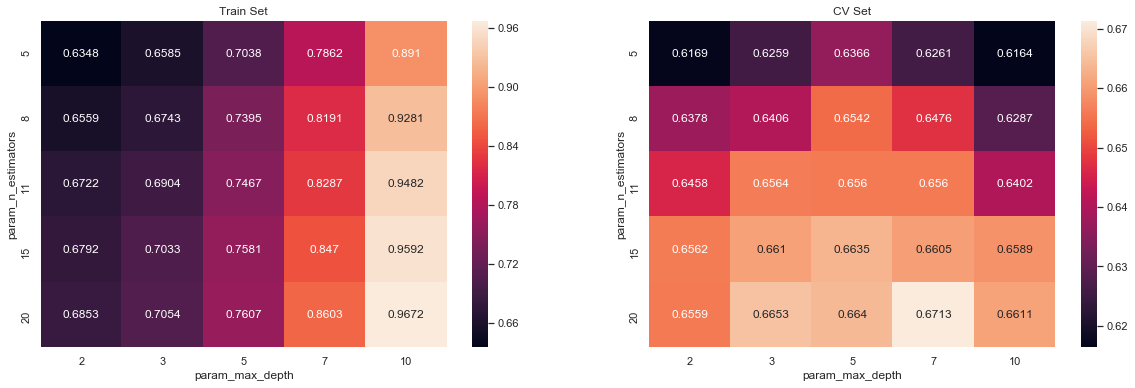

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

dt4 = RandomForestClassifier(class_weight='balanced',min_samples_split=3)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf4 = GridSearchCV(dt4, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se4 = clf4.fit(X_set4_train, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf4.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:
#Best Estimator Best tune parameters
print(clf4.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf4.score(X_set4_train,y_train))
print(clf4.score(X_set4_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.8283129595827274
0.6913695977389969


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[7] } ]

# Fitting Model to Hyper-Parameter Curve:

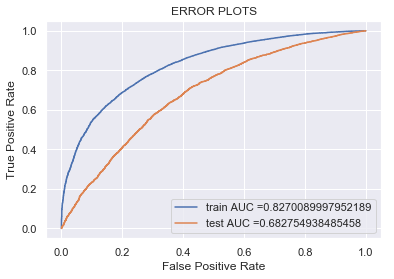

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 =GridSearchCV(RandomForestClassifier(class_weight='balanced',min_samples_split=3),best_tune_parameters)
clf11.fit(X_set4_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set4_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set4_test) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()


the maximum value of tpr*(1-fpr) 0.56 for threshold 0.51
the maximum value of tpr*(1-fpr) 0.41 for threshold 0.53


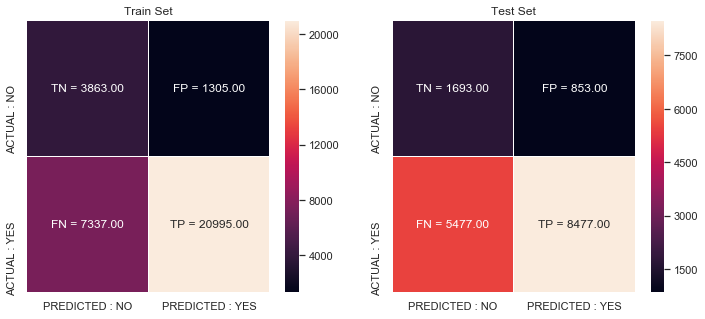

In [0]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Gradient Boosted Decision Trees

# GBDT on Bow

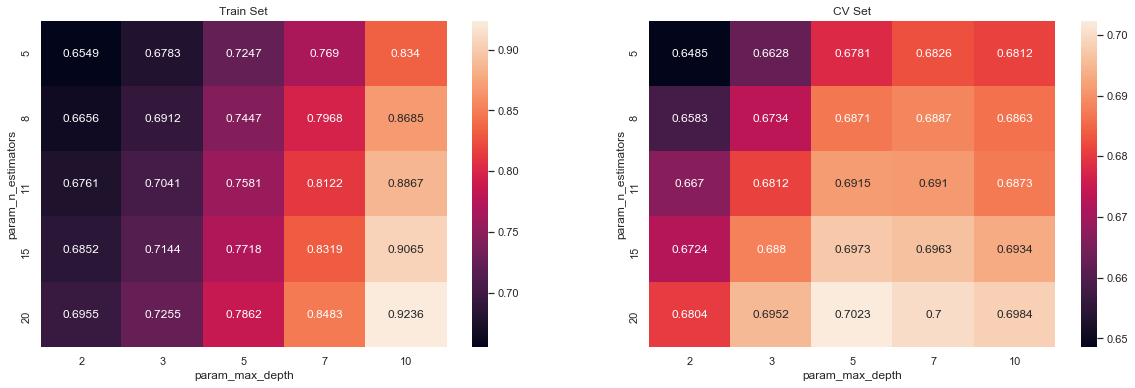

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
dt5 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf5 = GridSearchCV(dt5, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se5 = clf5.fit(X_set1_train, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf5.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:
#Best parameter
print(clf5.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf5.score(X_set1_train,y_train))
print(clf5.score(X_set1_test,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.766528371823216
0.7034997074328275


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

# Fitting Model to Hyper-Parameter Curve

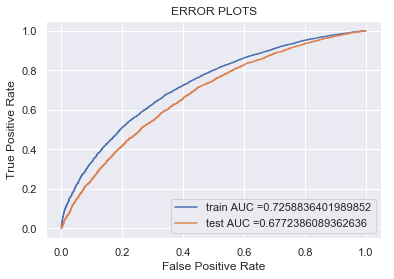

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_set1_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set1_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set1_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.45 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.4 for threshold 0.5


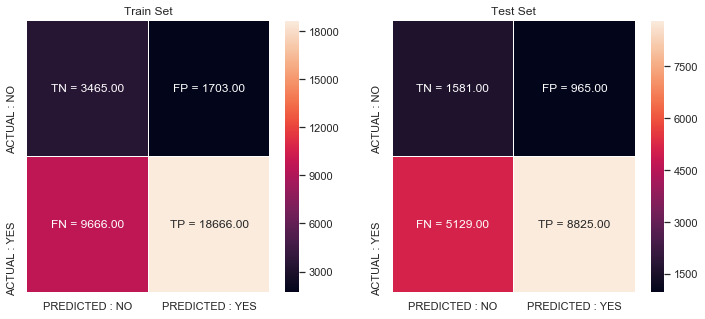

In [0]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# GBDT on tf-idf

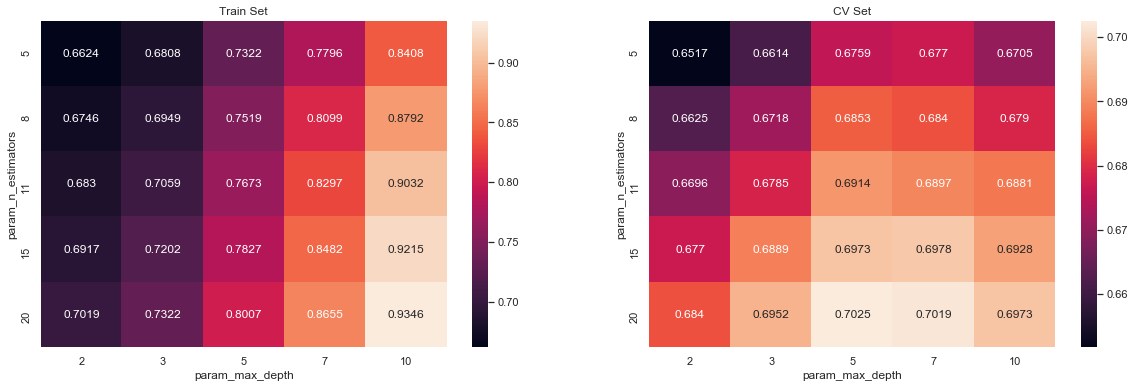

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt6 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf6 = GridSearchCV(dt6, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se6 = clf6.fit(X_set2_train, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf6.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:
#Best estimator
print(clf6.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf6.score(X_set2_train,y_train))
print(clf6.score(X_set2_test,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.7792738461777184
0.7055364185612225


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

# Fitting the best hyperparameter

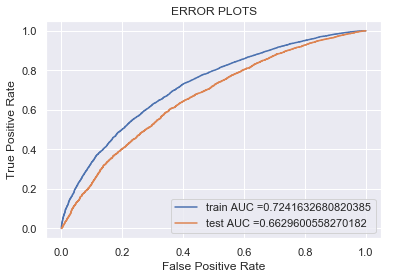

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_set2_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set2_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set2_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.44 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.39 for threshold 0.51


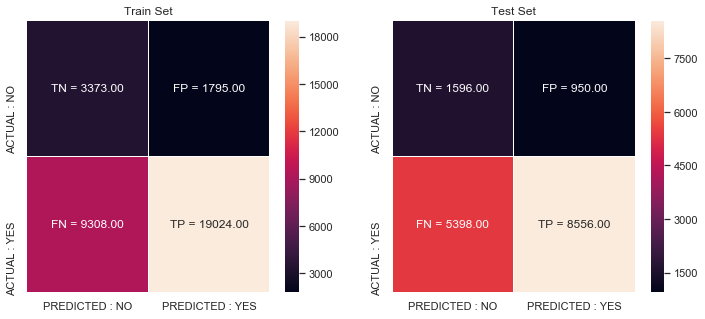

In [0]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# GBDT on w2v

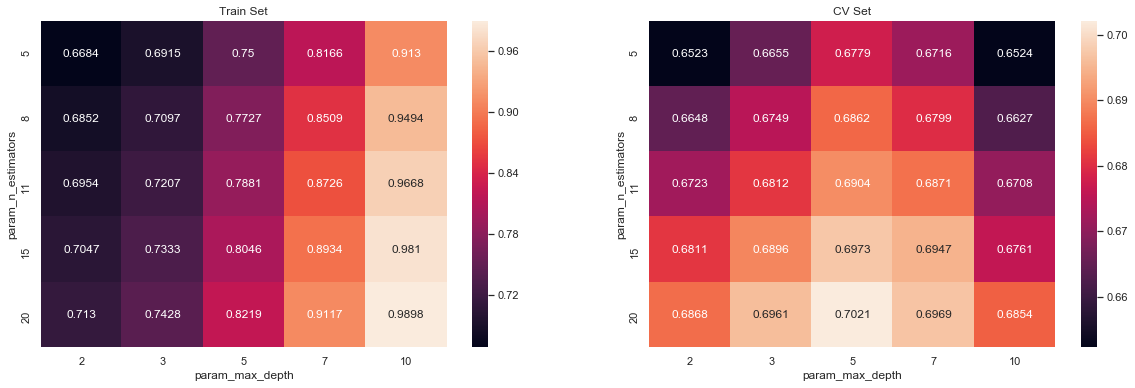

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

dt7 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf7 = GridSearchCV(dt7, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se7 = clf7.fit(X_set3_train, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf7.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()


In [0]:
#Best estimator
print(clf7.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf7.score(X_set3_train,y_train))
print(clf7.score(X_set3_test,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.7970955849570485
0.7095266925182631


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

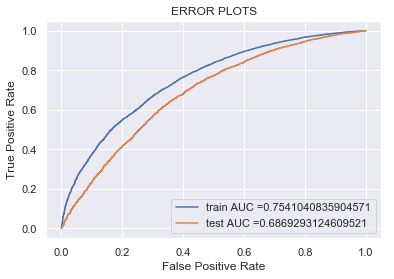

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_set3_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set3_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set3_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.47 for threshold 0.51
the maximum value of tpr*(1-fpr) 0.41 for threshold 0.52


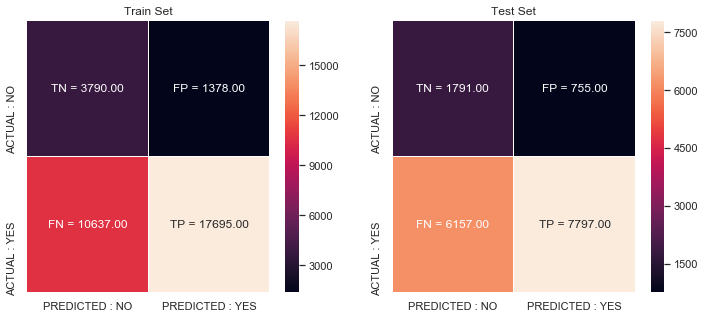

In [0]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Applying GBDT on tf-idf w2v

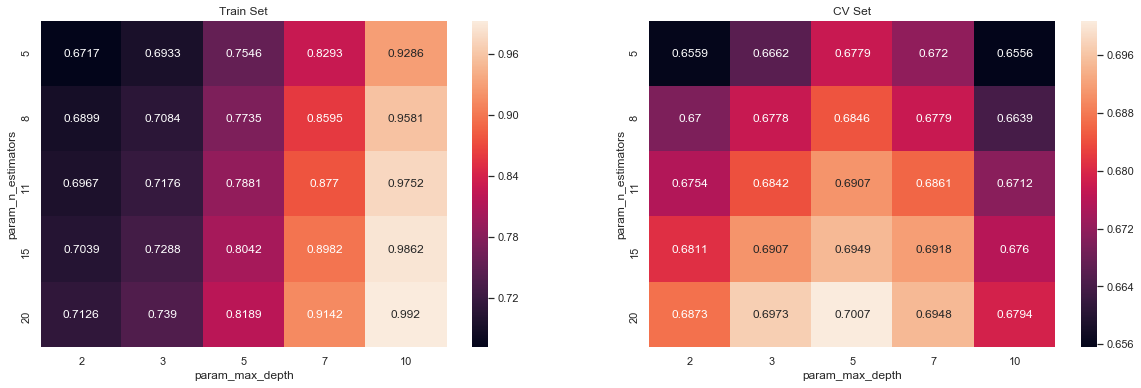

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt8 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf8 = GridSearchCV(dt8, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se8 = clf8.fit(X_set4_train, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf8.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:
print(clf8.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf8.score(X_set4_train,y_train))
print(clf8.score(X_set4_test,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.7967254402847878
0.7119651416656749


In [0]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

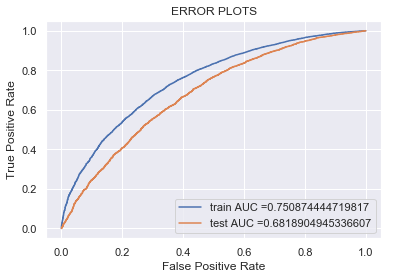

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_set3_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set3_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set3_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()


the maximum value of tpr*(1-fpr) 0.47 for threshold 0.51
the maximum value of tpr*(1-fpr) 0.4 for threshold 0.51


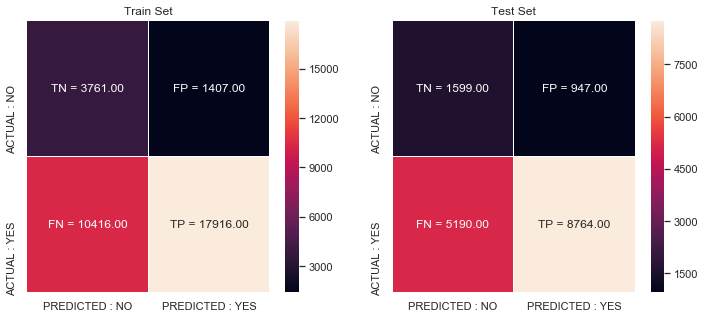

In [0]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

# Conclusions

In [0]:
# Please compare all your models using Prettytable library
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Model ", " Vectorizer ", " n_estimators", " max_depth "," Test -AUC ")
tb.add_row([ "Random Forest", " BOW ", 1000,10, 71.8 ])
tb.add_row([ "Random Forest", " Tf - Idf", 500 , 10 , 71.3 ])
tb.add_row([ "Random Forest", " AVG-W2V", 1000, 8 , 70.6 ])
tb.add_row([ "Random Forest", " A VG - Tf - Idf",20 , 7 , 68.2 ])
tb.add_row([ "Gradient Boosting DT", " Bow ",20 , 5 , 67.7 ])
tb.add_row([ "Gradient Boosting DT", " Tf - Idf",20 , 5 , 66.2 ])
tb.add_row([ "Gradient Boosting DT", " AVG-W2V", 20 , 5 , 68.6])
tb.add_row([ "Gradient Boosting DT", "A VG - Tf - Idf", 20 , 5 , 68.1 ])
print(tb.get_string(titles = "Random Forest and GBDT- Observations"))

+----------------------+------------------+---------------+-------------+-------------+
|        Model         |    Vectorizer    |  n_estimators |  max_depth  |  Test -AUC  |
+----------------------+------------------+---------------+-------------+-------------+
|    Random Forest     |       BOW        |      1000     |      10     |     71.8    |
|    Random Forest     |     Tf - Idf     |      500      |      10     |     71.3    |
|    Random Forest     |      AVG-W2V     |      1000     |      8      |     70.6    |
|    Random Forest     |  A VG - Tf - Idf |       20      |      7      |     68.2    |
| Gradient Boosting DT |       Bow        |       20      |      5      |     67.7    |
| Gradient Boosting DT |     Tf - Idf     |       20      |      5      |     66.2    |
| Gradient Boosting DT |      AVG-W2V     |       20      |      5      |     68.6    |
| Gradient Boosting DT | A VG - Tf - Idf  |       20      |      5      |     68.1    |
+----------------------+--------